# Wczytujemy dane

In [2]:
import os
import matplotlib.pyplot as plt

import sys
sys.path.append(r'C:\src\mne-python')
import mne

%matplotlib inline

In [3]:
from mne.time_frequency import psd_welch

In [4]:
%matplotlib inline

Plik ten sam co ostatnio (`'sternberg_diam_015_AK-epo.fif'`), tym razem wczytajcie go sami. Im mniej pomocy potrzebujecie przy tym (ze strony internetu, innych studentów), tym lepiej.

In [5]:
os.chdir(r'C:\Users\Sarenka\Dropbox\Sarenka\ZAJECIA\Analiza Danych EEG 2017 - 2018\dane')
epochs = mne.read_epochs('sternberg_diam_015_AK-epo.fif', preload=True)
sfreq = epochs.info['sfreq']

Reading sternberg_diam_015_AK-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
281 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
281 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


## Czas częstość - trochę teorii

Aby otrzymać reprezentację czas - częstość stosujemy najczęściej tak zwane falki, a szczególnie falki Morlet'a.
Falki morleta to takie sinusoidy 'wygładzone' gaussem. Zobaczmy sobie taką jedną:

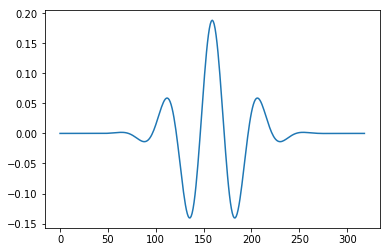

In [6]:
import numpy as np
from mne.time_frequency import morlet

wavelets = morlet(sfreq, [5., 10.], n_cycles=[4., 8.])

plt.plot(np.real(wavelets[0]))

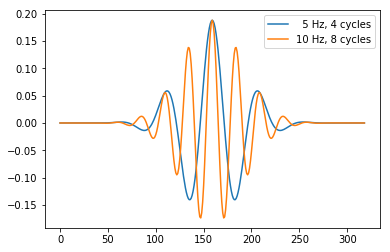

In [7]:
# wyświetlmy ddwie falki o różnej częstotliwości:
plt.plot(np.real(wavelets[0]), label='  5 Hz, 4 cycles')
plt.plot(np.real(wavelets[1]), label='10 Hz, 8 cycles')
plt.legend()

Falki to są takie tajemnicze istoty, które składają się z liczb zespolonych (mają część rzeczywistą oraz urojoną).  
Przykład jednej wartości wziętej ze środka falki:

In [8]:
dlugosc_falki = len(wavelets[0])
wavelets[0][int(dlugosc_falki / 2 + 6)]

(0.13483291925971841+0.12661653902671879j)

`0.13 + 0.12j` znaczy że dana wartość ma `0.13` jako swoją część rzeczywistą oraz `0.12` jako część urojoną.  
Dlaczego jednak w ogóle używać liczb zespolonych?
<div class="alert alert-success">
Liczby zespolone umożliwiają zawarcie w jednej wartości  
informacji o amplitudzie oraz fazie danej częstotliwości.
</div>

*Tutaj odrobina wyjaśnienia "wykładowcy"*

Przykład jak ważąc `sin` oraz `cos` możemy otrzymać sygnał o różnej fazie:

In [9]:
x = np.linspace(np.pi * -3, np.pi * 3, num=500)
sin = np.sin(x)
cos = np.cos(x)

(-1.5, 1.5)

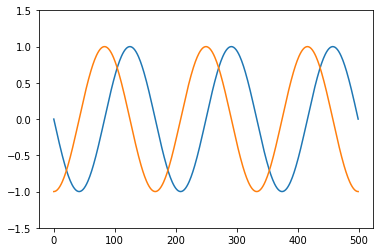

In [10]:
plt.plot(sin)
plt.plot(cos)
plt.ylim(-1.5, 1.5)

(-1.5, 1.5)

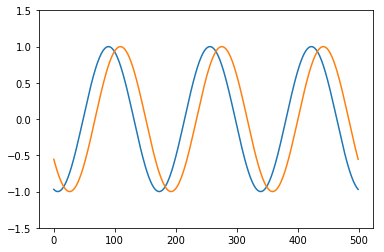

In [11]:
sig1 = 2 * sin + 8 * cos
sig2 = 6 * sin + 4 * cos

plt.plot(sig1 / sig1.max())
plt.plot(sig2 / sig2.max())
plt.ylim(-1.5, 1.5)

Powyżej normalizujemy amplitudę dzieląc przez maksimum danego sygnału (`sig1.max()`). Gdybyśmy robili to trygonometrycznie poprawnie to nie trzeba by było normalizować, ale tak jest łatwiej.

Używamy w związku z tym części urojonej i zespolonej falki aby w efekcie mieć informację nie tylko o amplitudzie ale i fazie sygnału. Jak wygląda część rzeczywista i urojona falki?

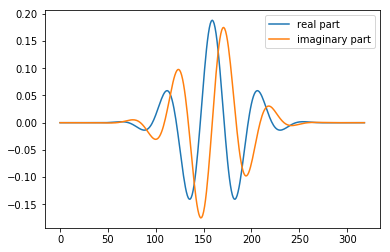

In [12]:
plt.plot(np.real(wavelets[0]), label='real part')
plt.plot(np.imag(wavelets[0]), label='imaginary part')
plt.legend()

### Splot
Musicie jeszcze zrozumieć na czym polega splot. Splot sygnału z jakimś innym (krótszym sygnałem) to trochę jakbyśmy przykładali ten krótszy sygnał w kolejnych punktach dłuższego i liczyli korelację. *tutaj potrzebne bardziej obrazowe wytłumaczenie*  
Zobaczmy sobie jak wygląda splot sygnału z okienkiem typu `boxcar`.

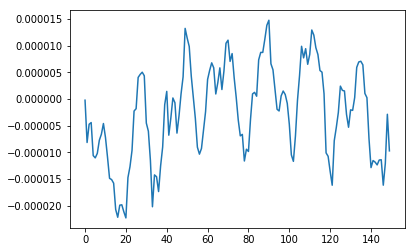

In [13]:
signal = epochs._data[8, 13, 250:400]
plt.plot(signal)

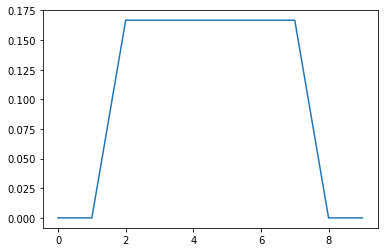

In [14]:
boxcar = np.array([0, 0, 1, 1, 1, 1, 1, 1, 0, 0]) / 6
plt.plot(boxcar)

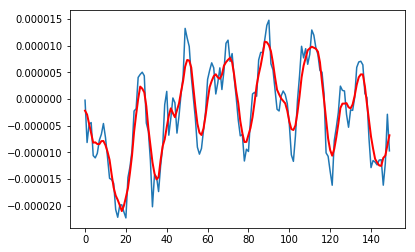

In [15]:
splot = np.convolve(signal, boxcar, mode='same')

plt.plot(signal)
plt.plot(splot, lw=2, color='r')

W efekcie wygładziliśmy sygnał - to, co zrobiliśmy jest analogiczne do kroczącej średniej.
<img src=http://bmia.bmt.tue.nl/education/courses/fev/course/notebooks/triangleblockconvolution.gif>

## Przykład 2 - wygładzenie + przesunięcie

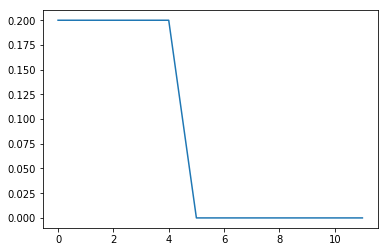

In [16]:
move = np.array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]) / 5
plt.plot(move)

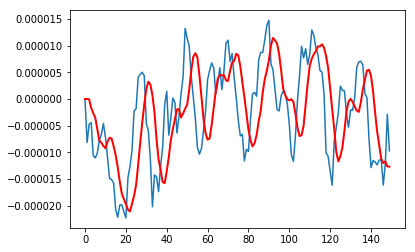

In [17]:
splot = np.convolve(signal, move[::-1], mode='same')

plt.plot(signal)
plt.plot(splot, lw=2, color='r')

Teraz dokonaliśmy jego wygładzenia, oraz przesunięcia.

## Przykład 3 - samo przesunięcie

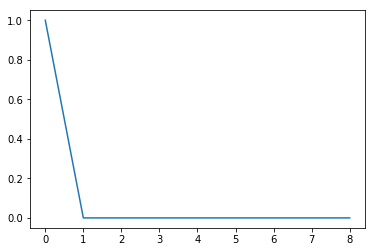

In [18]:
move = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0])
plt.plot(move)

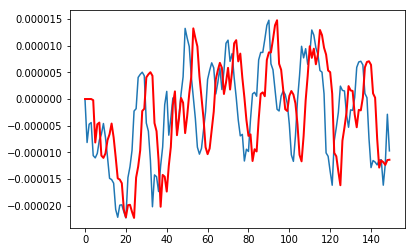

In [19]:
splot = np.convolve(signal, move[::-1], mode='same')

plt.plot(signal)
plt.plot(splot, lw=2, color='r')

A to było przesunięcie bez wygładzania.

## Przykład 4 - wykrywanie spadków

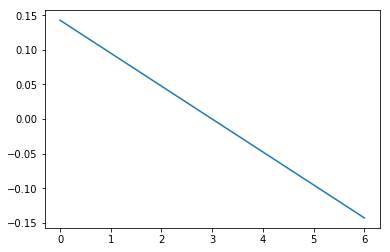

In [20]:
slope = np.linspace(1, -1, num=7) / 7
plt.plot(slope)

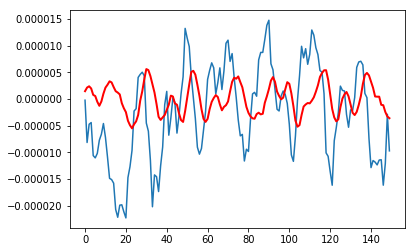

In [21]:
splot = np.convolve(signal, slope[::-1], mode='same')

plt.plot(signal)
plt.plot(splot, lw=2, color='r')

Teraz "wykrywaliśmy" z kolei strome spadki.  

## Znów falki
Wróćmy jednak do falek:

In [25]:
signal = epochs._data[8, 13, :]
wavelet = np.real(morlet(sfreq, [12], n_cycles=5)[0])
splot = np.convolve(signal, wavelet, mode='same')

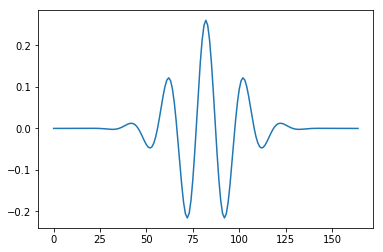

In [26]:
plt.plot(wavelet)

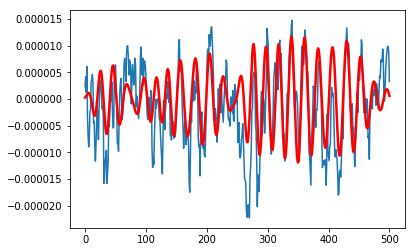

In [27]:
plt.plot(signal)
plt.plot(splot / 4, lw=2.5, color='r')

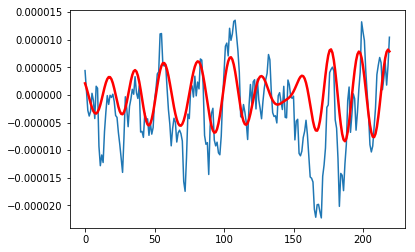

In [28]:
rng = slice(100, 320)
plt.plot(signal[rng])
plt.plot(splot[rng] / 5, lw=2.5, color='r')

Wykrywamy punkty w których sygnał jest zgodny z falką. Innymi słowy przefiltrowaliśmy sygnał.  

Warto zapamiętać że operacja filtrowania sygnału to po prostu splot sygnału z odpowiednią funkcją. Przy filtrowaniu częściej splatamy sygnał z funkcjami nieco innymi niż falki ponieważ nie chcemy odfiltrować tylko jednej częstotliwości ale cały ich zakres.  
Spadki i dołki wynikają "korelacji" dodatnich i ujemynych (sygnały w przeciwfazie korelują ujemnie).  
Jeżeli chcemy wiedzieć jak bardzo sygnał jest zgodny z falką niezależnie od fazy użyjemy całej falki, nie tylko jej części rzeczywistej.

In [29]:
wavelet = morlet(sfreq, [12], n_cycles=5)[0]
splot = np.convolve(signal, wavelet, mode='same')

Teraz wynik ma również wartości zespolone. Aby wybrać amplitudę używamy `np.abs`:

In [31]:
splot_abs = np.abs(splot)

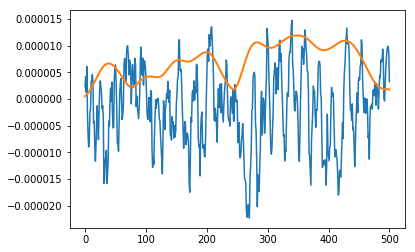

In [32]:
plt.plot(signal)
plt.plot(splot_abs / 4, lw=2)

Teraz widzimy jak bardzo sygnał jest podobny do falki **niezależnie od fazy**. Tak właśnie powstaje pojedyncza linijka wykresów czas-częstość.

## Czas-częstość

Wiemy już że reprezentacja czas-częstość (TFR - *Time-Frequency Representation*) powstaje w wyniku splotu falek (wyrażonych z użyciem liczb zespolonych) z sygnałem. Teraz możemy przejść wreszcie do przekształcenia sygnału do *TFR* z użyciem funkcji pakietu `mne`.

In [33]:
# importujemy numpy'a do operacji na macierzach
import numpy as np

# nazwa tej importowanej funkcji powinna być dla Was już jasna
from mne.time_frequency import tfr_morlet

Funkcja `tfr_morlet` przyjmuje dużo różnych argumentów (możecie sprawdzić w dokumentacji), ale przydadzą się nam najpierw podstawowe argumenty:
* `freq` - częstotliwości, których zawartość w sygnale chcemy sprawdzić. Ten argument definiuje częstotliwość użytej falki.
* `n_cycles` - liczba cykli falki (jeden cykl to jedna długość od grzbietu do następnego grzbietu, albo od dołka do dołka). Możemy zdefiniować tę samą liczbę cykli dla wszystkich częstotliwości, albo różną dla każdej częstotliwości.

In [34]:
# zadanie 1 co dzieje się poniżej? sprawdźcie dokumentację funkcji arange
freq = np.arange(3, 20)

# oraz zobaczcie co trafia nam do zmiennej freq:
print(freq)

[ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [35]:
# zadanie 2 - co dzieje się poniżej? jaki jest sens/cel definiowania liczby cykli w ten sposób?
n_cycles = freq / 2.5

In [36]:
# uruchamiamy analizę falkową
tfr = tfr_morlet(epochs['l4'], freq, n_cycles, use_fft=True,
                 return_itc=False, n_jobs=3, decim=20)

[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:    1.2s
[Parallel(n_jobs=3)]: Done  58 out of  63 | elapsed:    1.9s remaining:    0.1s
[Parallel(n_jobs=3)]: Done  63 out of  63 | elapsed:    1.9s finished


In [37]:
# Zadanie 3:
# Sprawdź w dokumnetacji tfr_morlet co kontrolują argumenty:
# * use_fft
# * return_itc
# * n_jobs
# * decim

No baseline correction applied


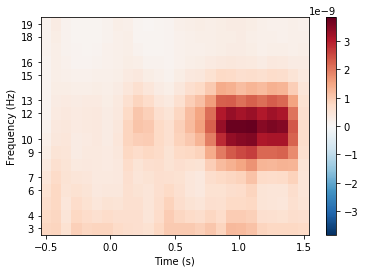

In [38]:
# checmy wyświetlić tfr dla elektrody PO3,
# najpierw szukamy indeksu elektrody
ch = epochs.ch_names.index('PO3')

# następnie korzystamy z metody plot obiektu tfr
tfr.plot([ch]);

Applying baseline correction (mode: percent)


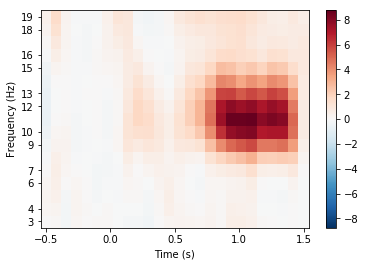

In [39]:
# "No baseline correction applied" - o co chodzi?
# tutaj kilka słów o baseline correction

# oraz wykres z korektą 'procentową' (<tutaj wstaw jakiś suchy żart odwołujący się do alkoholu>)
tfr.plot([ch], baseline=(-0.4, -0.1), mode='percent');

In [40]:
# Na razie wygląda to podobnie, później sprawdzimy przykłady z większą różnicą

In [41]:
# robimy czas-częstość dla warunku load2 oraz load4
freq = np.arange(3, 20, 0.25)
n_cycles = freq / 2.5

tfr_2 = tfr_morlet(epochs['l2'], freq, n_cycles, use_fft=True,
                   return_itc=False, n_jobs=3)
tfr_4 = tfr_morlet(epochs['l4'], freq, n_cycles, use_fft=True,
                   return_itc=False, n_jobs=3)

[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:    1.7s
[Parallel(n_jobs=3)]: Done  63 out of  63 | elapsed:    4.2s finished
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:    1.7s
[Parallel(n_jobs=3)]: Done  63 out of  63 | elapsed:    4.3s finished


In [9]:
# przykład z interaktywną wizualizacją, odkomentowujemy kod poniżej
#%matplotlib

Using matplotlib backend: Qt5Agg


Applying baseline correction (mode: percent)


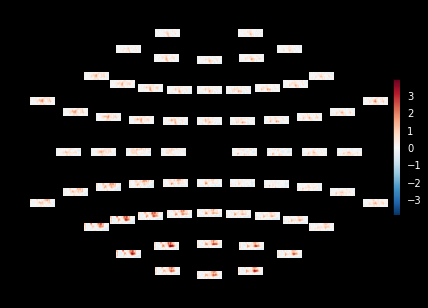

In [34]:
tfr_2.plot_topo(baseline=(-0.4, -0.1), mode='percent');

In [11]:
%matplotlib inline

Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)


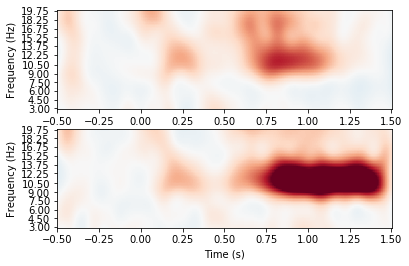

In [42]:
# naoczne porównanie dwóch warunków
ch = epochs.ch_names.index('PO3')

fig, ax = plt.subplots(nrows=2)
tfr_2.plot([ch], baseline=(-0.4, -0.1), mode='percent', axes=ax[0], show=False,
           vmin=-5, vmax=5, colorbar=False);
tfr_4.plot([ch], baseline=(-0.4, -0.1), mode='percent', axes=ax[1],
           vmin=-5, vmax=5, colorbar=False);

In [44]:
freq

array([10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49])

In [47]:
freq = np.arange(10, 50, 3)
n_cycles = 3

test1 = tfr_morlet(epochs['l4'], freq, n_cycles, use_fft=True,
                 return_itc=False, n_jobs=3, decim=20, picks=[ch])

[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.3s finished


Applying baseline correction (mode: logratio)


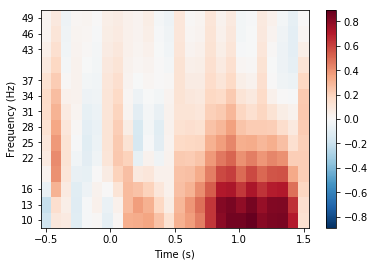

In [49]:
test1.plot([0], baseline=(-0.4, -0.1), mode='logratio');

Applying baseline correction (mode: logratio)


[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.3s finished


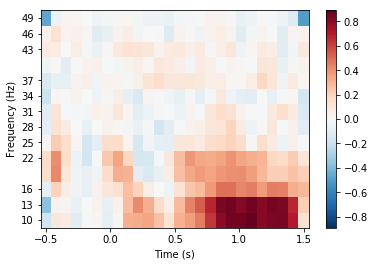

In [50]:
freq = np.arange(10, 50, 3)
n_cycles = np.linspace(3, 20, num=len(freq))

test2 = tfr_morlet(epochs['l4'], freq, n_cycles, use_fft=True,
                 return_itc=False, n_jobs=3, decim=20, picks=[ch])
test2.plot([0], baseline=(-0.4, -0.1), mode='logratio');

Applying baseline correction (mode: logratio)


[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.3s finished


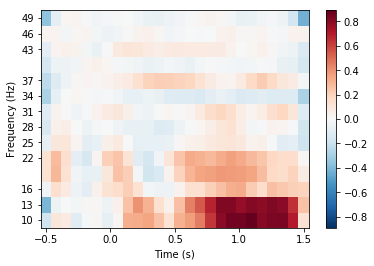

In [51]:
freq = np.arange(10, 50, 3)
n_cycles = np.linspace(3, 40, num=len(freq))

test2 = tfr_morlet(epochs['l4'], freq, n_cycles, use_fft=True,
                 return_itc=False, n_jobs=3, decim=20, picks=[ch])
test2.plot([0], baseline=(-0.4, -0.1), mode='logratio');

# Pętle
Nagle, w najmniej spodziewanym momencie, prowadzący zakłada Wam na szyję pętlę.

In [53]:
taśma_słoików = ['Masło orzechowe', 'Nutella', 'Pomidory krojone', 'Korniszony', 'Gawrony']

for słoik in taśma_słoików:
    print(słoik)

Masło orzechowe
Nutella
Pomidory krojone
Korniszony
Gawrony


In [55]:
for słoik in taśma_słoików:
    if len(słoik) > 10:
        print(słoik)

Masło orzechowe
Pomidory krojone
